<a href="https://colab.research.google.com/github/dylan-greenberg/Python-Projects-Labs/blob/main/Lab11_MegaTelCo_ProfitModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 4487 Lab 11

## Outline

What do you need to know for this module's project?

1. Fit a tree model using all the available predictors.
2. Create a confusion matrix  and identify numbers of TP, FP, TN and FN.
3. Estimate profit (benefits - costs) using a defined cost-benefit matrix and the above confusion matrix.
4. Estimate profit for a strategy that consists in calling everyone.
5. Estimate profit for a class decision threshold of .3
6.  Use the model to predict on a new dataset (without the target), then use these predictions to identify those who should be called--a contact list.
7.  Make a recommendation to the Director of Sales based on your analytic work.

**NOTE:** For the module 5 project you will predict answering for prospective customers (who have not yet been called). Consequently, the assignment requires an additional dataset, customer_data.csv, that you will need to download and move into your project folder.  Here is code to load that data into memory after you have it saved in your project folder (your working directory). This code is included in the template script.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab11_megatelco_tune_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Megatelco Data Dictionary

 DEMOGRAPHIC VARIABLES:
 - College - has the customer attended some college (one, zero)
 - Income - annual income of customer
 - House - estimated price of the customer's home (if applicable)

 USAGE VARIABLES:
 - Data Overage Mb - Average number of megabytes that the customer used in excess of the plan limit (over last 12 months)
 - Data Leftover Mb - Average number of megabytes that the customer use was below the plan limit (over last 12 months)
 - Data Mb Used - Average number of megabytes used per month (over last 12 months)
 - Text Message Count - Average number of texts per month (over last 12 months)
 - Over 15 Minute Calls Per Month - Average number of calls over 15 minutes in duration per month (over last 12 months)
 - Average Call Duration- Average call duration (over last 12 months)

PHONE VARIABLES:
 - Operating System - Current operating system of phone
 - Handset Price - Retail price of the phone used by the customer

ATTITUDINAL VARIABLES:
 - Reported Satisfaction - Survey response to "How satisfied are you with your current phone plan?" (high, med, low)
 - Reported Usage Level - Survey response to "How much do your use your phone?" (high, med, low)
 - Considering Change of Plan - Survey response to "Are you currently planning to change companies when your contract expires?" (high, med, low)

OTHER VARIABLES
 - Leave - Did this customer churn with the last contract expiration? (LEAVE, STAY)
 - ID - Customer identifier

##Load Libraries

In this class we will be using
- Pandas
- Scikitlearn
- Matplotlib


In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix


## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the Megatelco dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/Labs/DataSets/megatelco_leave_survey.csv')
df.head()

,college,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id,operating_system
0,one,403137,70,0,6605,199,841317,653,5.0,8,low,low,yes,LEAVE,8183,Android
1,zero,129700,67,16,6028,134,476664,1193,5.0,5,low,low,yes,LEAVE,12501,IOS
2,zero,69741,60,0,1482,176,810225,1037,3.0,8,low,low,yes,STAY,7425,IOS
3,one,377572,0,22,3005,184,826967,1161,0.0,5,low,low,no,LEAVE,13488,IOS
4,zero,382080,0,0,1794,74,951896,1023,0.0,14,low,low,yes,STAY,11389,IOS


## Clean up the data
Did you notice anything unusual about the "house" amounts?

How about the handset price and income?

Clean up the data in a  new datafram named "df_clean"


In [3]:
#delete rows with outlier data; put it in a new dataframe
df_clean = df[(df['house'] > 0) & (df['income'] > 0) & (df['handset_price'] < 1000)]

#delete any rows with missing values in the clean dataframe
df_clean = df_clean.dropna()

df_clean.describe()

,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,10412.000000,10412.000000,10412.000000,10412.000000,10412.000000,1.041200e+04,10412.000000,10412.000000,10412.000000,10412.000000
mean,242068.987706,153.847003,37.472436,4195.399827,135.500000,8.758348e+05,607.473492,10.571072,9.747503,11839.793988
std,109041.788157,113.013727,28.015291,2205.189091,48.916131,2.868363e+05,225.506388,8.444673,5.180381,6805.159729
min,52491.000000,0.000000,0.000000,400.000000,52.000000,3.202380e+05,215.000000,0.000000,1.000000,2.000000
25%,148548.000000,55.000000,12.000000,2290.750000,93.000000,6.447640e+05,413.000000,3.000000,5.000000,6070.750000
50%,241663.000000,151.000000,35.000000,4206.500000,135.000000,8.730785e+05,608.000000,9.000000,10.000000,11743.000000
75%,335660.500000,242.000000,62.000000,6079.250000,178.000000,1.098298e+06,802.000000,17.000000,14.000000,17330.500000
max,431916.000000,380.000000,89.000000,8000.000000,220.000000,1.456389e+06,999.000000,35.000000,19.000000,25354.000000


# Standardize attributes

- Convert "college" to 0,1
- Convert reported_satisfaction to 1,2,3
- Convert reported_usage_level to 1,2,3
- Convert considering_change_of_plan to 0,1
- Convert leave to 0,1

I'm going to leave the "leave" variable in place, just in case I need the original value

In [4]:
df_clean.loc[df_clean['college'] == 'one', 'college'] = "1"
df_clean.loc[df_clean['college'] == 'zero', 'college'] = "0"
df_clean.loc[df_clean['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean.loc[df_clean['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean.loc[df_clean['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean.loc[df_clean['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean.loc[df_clean['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean.loc[df_clean['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean.loc[df_clean['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean.loc[df_clean['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean.loc[df_clean['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

df_clean['college'] = df_clean['college'].astype('int')
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('int')
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('int')
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('float')

#Add new field with binary value for leave
df_clean['leave_flag'] = df_clean['leave'].str.replace('STAY','0')
df_clean['leave_flag'] = df_clean['leave_flag'].str.replace('LEAVE','1')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('int')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('bool')

df_clean.head(10)

,college,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id,operating_system,leave_flag
0,1,403137,70,0,6605,199,841317,653,5.0,8,1,1,1.0,LEAVE,8183,Android,True
7,1,131230,0,0,4489,89,613744,365,5.0,10,1,3,1.0,STAY,18170,Android,False
8,1,193667,0,0,1023,76,949829,347,1.0,8,3,1,0.0,LEAVE,3201,Android,True
9,1,419573,0,74,4631,209,818027,640,0.0,2,1,1,1.0,LEAVE,12612,Android,True
10,0,262085,222,17,530,95,781944,692,10.0,1,3,3,1.0,LEAVE,3266,Android,True
11,1,310841,74,14,7025,180,979451,835,3.0,5,3,1,0.0,STAY,13155,IOS,False
12,0,398292,0,0,3681,93,878343,248,0.0,9,2,2,0.0,LEAVE,1491,Android,True
13,0,192245,96,40,4806,139,1141088,476,4.0,2,1,3,1.0,LEAVE,13418,Android,True
16,1,236152,0,21,3881,189,1364832,745,13.0,6,3,1,1.0,STAY,3335,Android,False
17,1,422168,0,10,794,213,909127,874,1.0,4,3,1,1.0,STAY,80,IOS,False


# Convert attributes to factors

- Leave
- College
- Reported satisfaction
- Reported usage level
- Considering change of plan

In [5]:
df_clean['leave'] = df_clean['leave'].astype('category')
df_clean['college'] = df_clean['college'].astype('category')
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('category')
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('category')
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('category')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10412 entries, 0 to 14998
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   college                      10412 non-null  category
 1   income                       10412 non-null  int64   
 2   data_overage_mb              10412 non-null  int64   
 3   data_leftover_mb             10412 non-null  int64   
 4   data_mb_used                 10412 non-null  int64   
 5   text_message_count           10412 non-null  int64   
 6   house                        10412 non-null  int64   
 7   handset_price                10412 non-null  int64   
 8   over_15mins_calls_per_month  10412 non-null  float64 
 9   average_call_duration        10412 non-null  int64   
 10  reported_satisfaction        10412 non-null  category
 11  reported_usage_level         10412 non-null  category
 12  considering_change_of_plan   10412 non-null  category
 13  leave 

# What is the base probability of leaving?

If we use no model at all, how good is our chance of predicting someone leaving?

In [6]:
df_clean['leave_flag'].mean()

0.4990395697272378

#Split the training and testing datasets

In [7]:
# split the datafram into independent (x) and dependent (predicted) attributes (y)
x = df_clean[['income','house','college','data_overage_mb','data_leftover_mb','text_message_count','handset_price','over_15mins_calls_per_month','average_call_duration','reported_satisfaction','reported_usage_level','considering_change_of_plan']]
y = df_clean['leave_flag']

#place 20% of data in a test dataframe
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Fit a basic tree model

Use all available attributes

In [8]:


megatelco_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco_tree = megatelco_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict = megatelco_tree.predict(x_test)




## What is the accuracy?

Is it better than the 49% base probability?

In [9]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.6629860777724436


# Create a confusion matrix

This will show false positives, true positives, etc.

In [10]:
# create a confusion matrix
megatelco_tree_matrix = confusion_matrix(y_test, y_predict)
print(megatelco_tree_matrix)

[[383 669]
 [ 33 998]]


## Plot the confusion matrix

We will use a Seaborn library for this

[Text(0, 0.5, 'Stay'), Text(0, 1.5, 'Leave')]

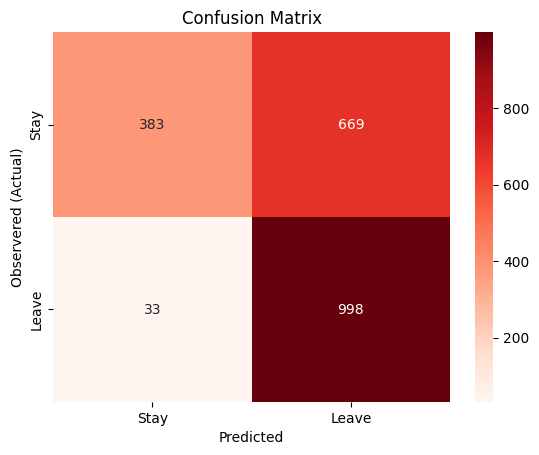

In [11]:
#Create a heatmap from our confusion matrix
cm = sns.heatmap(megatelco_tree_matrix, annot=True, fmt='d',cmap='Reds')

cm.set_title('Confusion Matrix');
cm.set_xlabel('Predicted')
cm.set_ylabel('Observered (Actual)');

cm.xaxis.set_ticklabels(['Stay','Leave'])
cm.yaxis.set_ticklabels(['Stay','Leave'])

## Calculate Profit

Using the confusion matrix in the previous question how much profit (revenue - costs) could be expected with these costs-benefits?

For MegaTelCo we will assume benefit (revenue) = 800 and cost = 200.  TPs are a benefit, FPs are a cost. Again, we ignore those predicted to stay. (The cost-benefit numbers will be different in the AdviseInvest case! )

Why are TPs a benefit? In the MegaTelCo scenario, these are customers who are predicted to leave and actually were going to leave. If your marketing campaign is successful, then you can convince them to stay, thereby saving the company money. (In the AdviseInvest scenario, TPs are customers that you have predicted will answer the phone and do answer, thus providing an opportunity for your sales reps to make a sale.)

**Assume you can save 100% of the people who were actually going to leave.**  

In [18]:
# True leavers * 600 -> You rescued these leave-leave people
# False leavers * 200 -> You wasted your money on the leave-stay people since they weren't actually going to leave
(998 * (800-200)) - (669 * 200)

465000

## Fine tune the model

Adjust the threshold for giving offers down to 0.2.  What happens to profit?

The default threshold is 0.5 or 50% likely to make a choice.  If we adjust to 0.20, we are looking for customers with even a 20% chance of leaving.   This will lead to more offers being made and more false positives.  



In [58]:


megatelco2_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco2_tree = megatelco2_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict2 = (megatelco2_tree.predict_proba(x_test)[:,1] >= 0.2)


# create a confusion matrix
megatelco2_matrix = confusion_matrix(y_test, y_predict2)
print(megatelco2_matrix)



[[ 292  760]
 [   0 1031]]


## Create a new confusion matrix

[Text(0, 0.5, 'Stay'), Text(0, 1.5, 'Leave')]

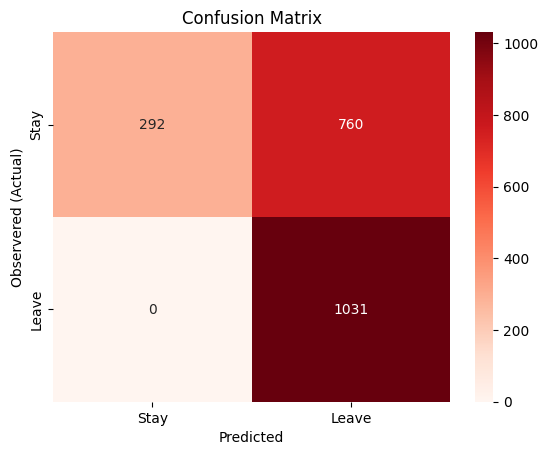

In [20]:
import seaborn as sns

#Create a heatmap from our confusion matrix
cm = sns.heatmap(megatelco2_matrix , annot=True, fmt='d',cmap='Reds')

cm.set_title('Confusion Matrix');
cm.set_xlabel('Predicted')
cm.set_ylabel('Observered (Actual)');

cm.xaxis.set_ticklabels(['Stay','Leave'])
cm.yaxis.set_ticklabels(['Stay','Leave'])


## Calculate profite for new model

In [22]:
# True leavers * 600 -> You rescued these leave-leave people
# False leavers * 200 -> You wasted your money on the leave-stay people since they weren't actually going to leave
( 1031 * (800-200)) - (760 * 200)

466600

## Optimize the Model

➡️ Assignment Tasks
What is the optimal profit possible?  Iterate through multiple probability levels to find the shape of the profitability curve.
- Create at least 5 different confusion matrix versions at different probability levels.   Your last version should be the most profitable

Thresholds: [0.3, 0.4, 0.5, 0.6, 0.7]
Profits: [465000, 465000, 465000, 206000, 150600]
Optimal Threshold: 0.3
Optimal Profit: 465000


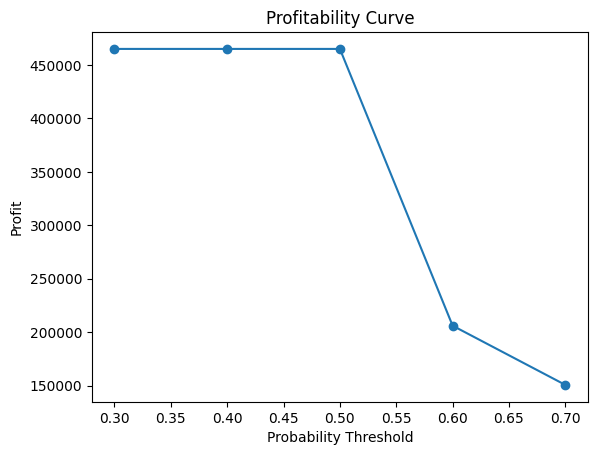

In [94]:
import numpy as np
from sklearn.metrics import confusion_matrix

probabilities = megatelco2_tree.predict_proba(x_test)[:, 1]
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
profits = []
confusion_matrices = []

benefit_per_tp = 600
cost_per_fp = 200

for threshold in thresholds:

    predictions = (probabilities >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    confusion_matrices.append((tn, fp, fn, tp))

    profit = (tp * benefit_per_tp) - (fp * cost_per_fp)
    profits.append(profit)

optimal_threshold = thresholds[np.argmax(profits)]
optimal_profit = max(profits)

print("Thresholds:", thresholds)
print("Profits:", profits)
print("Optimal Threshold:", optimal_threshold)
print("Optimal Profit:", optimal_profit)

import matplotlib.pyplot as plt

plt.plot(thresholds, profits, marker='o')
plt.xlabel('Probability Threshold')
plt.ylabel('Profit')
plt.title('Profitability Curve')
plt.show()

In [ ]:
# 0.30 probability yields the most profit. At a .30 probability we are giving the least amount of incorrect leave offers while generating the most revenue.

In [60]:
megatelco3_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco3_tree = megatelco3_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict3 = (megatelco3_tree.predict_proba(x_test)[:,1] >= 0.3)


# create a confusion matrix
megatelco3_matrix = confusion_matrix(y_test, y_predict3)
print(megatelco3_matrix)

[[383 669]
 [ 33 998]]


In [61]:
(600*998)-(200*669)

465000

In [81]:
megatelco4_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco4_tree = megatelco4_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict4 = (megatelco4_tree.predict_proba(x_test)[:,1] >= 0.4)


# create a confusion matrix
megatelco4_matrix = confusion_matrix(y_test, y_predict4)
print(megatelco4_matrix)

[[383 669]
 [ 33 998]]


In [82]:
(600*998)-(200*669)

465000

In [86]:
megatelco5_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco5_tree = megatelco5_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict5 = (megatelco5_tree.predict_proba(x_test)[:,1] >= 0.5)


# create a confusion matrix
megatelco5_matrix = confusion_matrix(y_test, y_predict5)
print(megatelco5_matrix)

[[383 669]
 [ 33 998]]


In [85]:
(998*600)-(200*669)

465000

In [88]:
megatelco5_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco5_tree = megatelco5_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict5 = (megatelco5_tree.predict_proba(x_test)[:,1] >= 0.52)


# create a confusion matrix
megatelco5_matrix = confusion_matrix(y_test, y_predict5)
print(megatelco5_matrix)

[[922 130]
 [630 401]]


In [89]:
(401*600)-(130*200)

214600

In [92]:
megatelco5_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco5_tree = megatelco5_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict5 = (megatelco5_tree.predict_proba(x_test)[:,1] >= 0.3)


# create a confusion matrix
megatelco5_matrix = confusion_matrix(y_test, y_predict5)
print(megatelco5_matrix)

[[383 669]
 [ 33 998]]


In [93]:
(998*600)-(669*200)

465000